In [48]:
import numpy as np
from numpy import radians, pi
from lib.cartpolesystem import CartPoleSystem
from lib.cartpoleenv import CartPoleEnv
from lib.colors import Colors
from lib.direct_collocation import DirectCollocation
import time
from lib.controllers import LQR
from time import perf_counter
from matplotlib import pyplot as plt
from scipy.io import savemat

In [49]:
dt = 0.01
g = 9.81

n = 1
system_noise = 0 * np.diag(np.ones(2+2*n))

system = CartPoleSystem(
    (0.0, 0.5, 0.005, -0.8, 0.8, Colors.red),
    (0.2, 8.7e-5, 8.7e-5, 0.02, 0.05, -2400.0, 2400.0, Colors.black),
    [
        (0, 0.1, 0.2, 0.001, Colors.green),
    ],
    g,
    dt,
    "rk4",
    "nonlinear",
    system_noise
)

env = CartPoleEnv(system, dt, g)
env.observation_space.shape

(4, 1)

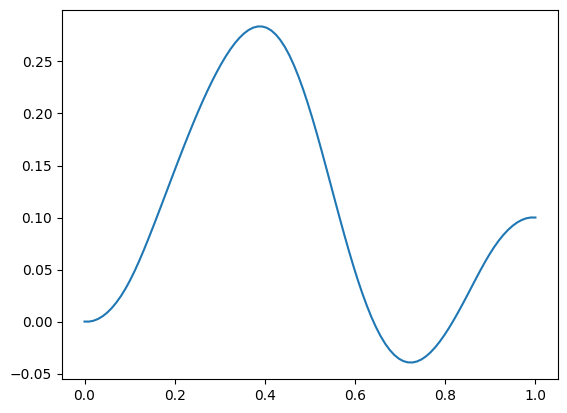

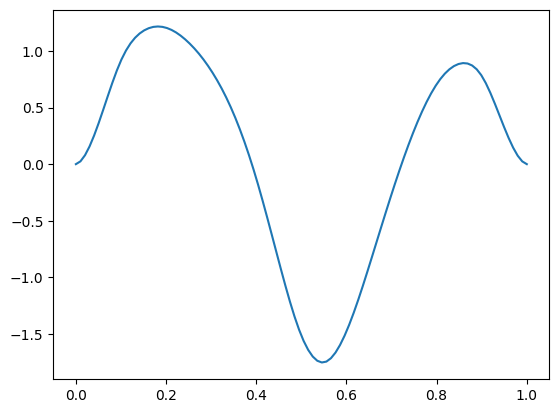

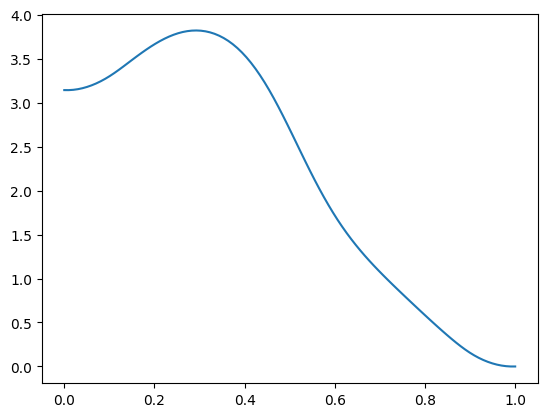

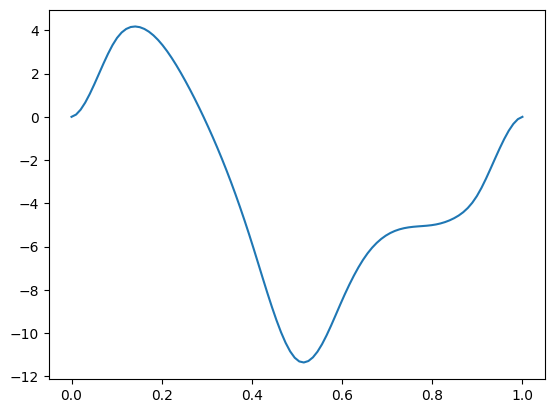

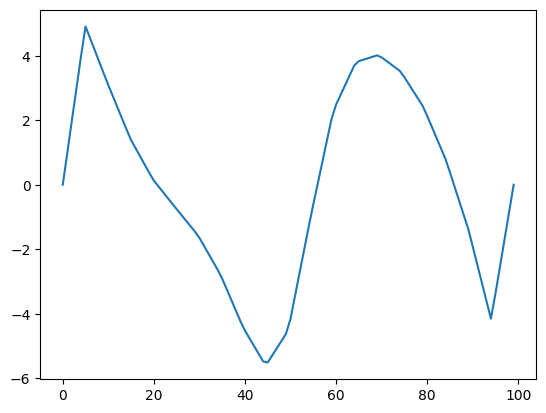

In [50]:
direct_collocation = DirectCollocation(
    21, 
    system.differentiate, 
    env.observation_space.shape[0],
    env.action_space.shape[0]
)

x0 = np.vstack([0, 0, radians(180), 0])

r = np.vstack(
    [0.1, 0, 0, 0]
)

u0 = np.vstack([0])
ur = np.vstack([0])

end_time = 1
N = int(end_time/dt)

last_update = perf_counter()

state, control = direct_collocation.make_controller(end_time, N, x0, r, u0, ur)

time = np.linspace(0, end_time, N)

for s in state:
    plt.plot(time, s)
    plt.show()
plt.plot(control[0])
plt.show()


In [51]:
linearization_x0 = np.zeros((2+2*n, 1))
linearization_u0 = np.vstack([0])

# A, B = system.linearize_old()
A, B = system.linearize(linearization_x0, linearization_u0)

C = np.eye(2+2*n)
D = np.zeros((2+2*n, 1))

ct_dt = dt

sys = LQR(A, B, C, D, dt=ct_dt)

Q = np.eye(2+2*n)
R = np.diag([0.1])

sys.calculate_K_lqr(Q, R)
sys.calculate_K_r()

In [55]:
last_update = perf_counter()

obs, _ = env.reset(x0)

time_longer = 10
N_longer = int(time_longer/dt)

for i in range(N_longer):
    while perf_counter() < last_update + dt:
        pass
    last_update = perf_counter()
    
    u = sys.feedback_d(obs, r)
    max_Ia = 100
    max_Va_from_Ia = system.Ra * max_Ia + system.K*obs[1]/system.r
    min_Va_from_Ia = -max_Va_from_Ia

    if u[0] > min(system.max_Va, max_Va_from_Ia):
        u[0] = min(system.max_Va, max_Va_from_Ia)
    elif u[0] < max(system.min_Va, min_Va_from_Ia):
        u[0] = max(system.min_Va, min_Va_from_Ia)

    if i < N*0.8:
        u = np.vstack([control[0][i]])

    obs, reward, done, msg, _ = env.step(u)
    env.render()
env.close()

AttributeError: 'NoneType' object has no attribute 'fill'